In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
from google.colab import drive
import torch.nn.functional as F
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_dataset=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw2/Data/HW2_data/Q3_train.csv')
test_dataset=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw2/Data/HW2_data/Q3_test.csv')
train1 = train_dataset.copy(deep = True)
test1 = test_dataset.copy(deep = True)
train_images = train1.iloc[:, 1:].to_numpy(dtype = 'float32')
test_images = test1.iloc[:, 1:].to_numpy(dtype = 'float32')
train_labels = train_dataset['label'].values
test_labels = test_dataset['label'].values
train_images = train_images.reshape(train_images.shape[0],1,28,28)
test_images = test_images.reshape(test_images.shape[0],1,28,28)
print(train_images.shape)
print(test_images.shape)

(27455, 1, 28, 28)
(7172, 1, 28, 28)


In [ ]:
device = "cpu"
train_images_tensors = torch.from_numpy(train_images).to(device)
train_labels_tensors = torch.from_numpy(train_labels).to(device)

test_images_tensors = torch.from_numpy(test_images).to(device)
test_labels_tensors = torch.from_numpy(test_labels).to(device)

train_dataset = TensorDataset(train_images_tensors, train_labels_tensors)
test_dataset = TensorDataset(test_images_tensors, test_labels_tensors)

In [ ]:
train_images_tensors.dtype

torch.float32

In [ ]:
train_ds, validation_ds = train_test_split(train_dataset, test_size=0.25, random_state=42)
len(train_ds), len(validation_ds), len(test_dataset)

(20591, 6864, 7172)

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 10
input_size=784
num_classes=26

16

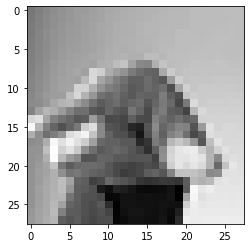

In [ ]:
train_ds[5][1]
plt.imshow(train_ds[5][0].squeeze(), cmap="gray")
train_ds[5][1].item()

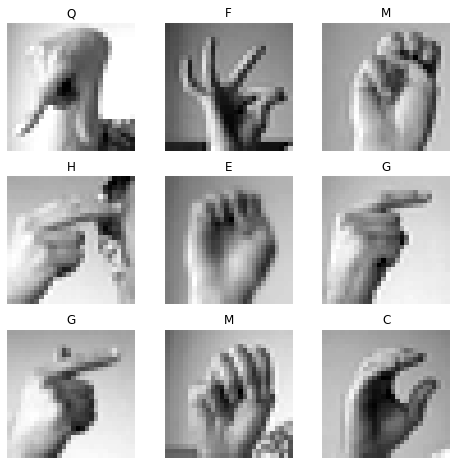

In [ ]:
labels_map = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",10:"K",11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",24:"Y"}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset ), size=(1,)).item()
    img, _ = train_dataset[sample_idx]
    _, label = train_dataset[sample_idx]
    label = labels_map[label.item()]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

train_images_tensors = torch.from_numpy(train_images).to(device)
train_labels_tensors = torch.from_numpy(train_labels).to(device)

test_images_tensors = torch.from_numpy(test_images).to(device)
test_labels_tensors = torch.from_numpy(test_labels).to(device)

train_dataset = TensorDataset(train_images_tensors, train_labels_tensors)
test_dataset = TensorDataset(test_images_tensors, test_labels_tensors)

train_ds, validation_ds = train_test_split(train_dataset, test_size=0.25, random_state=42)
len(train_ds), len(validation_ds), len(test_dataset)

Using cpu device


(20591, 6864, 7172)

In [ ]:
train_dataloader = DataLoader(train_ds, batch_size, shuffle=True)
val_dataloader = DataLoader(validation_ds, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size,  shuffle=True)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return (torch.tensor(torch.sum(preds == labels).item() / len(preds)))*100

In [ ]:
class NeuralNetwork(nn.Module):

    def __init__(self, in_size, out_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_size, 416)
        self.linear2 = nn.Linear(416,208)
        self.linear3 = nn.Linear(208,104)
        # self.linear4 = nn.Linear(104,52)
        self.linear5=nn.Linear(104,26)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        # x = self.linear4(x)
        # x = self.relu(x)
        logits =self.linear5(x)
        return logits
    def training_part(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def train_part(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'train_loss': loss, 'train_acc': acc}
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}

    def validation_part(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def test_part(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'test_loss': loss, 'test_acc': acc}
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

    def epoch_end(self, epoch,  trn_r, val_r, tst_r):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(epoch, trn_r['train_loss'], trn_r['train_acc']))
        print("Epoch [{}], validation_loss: {:.4f}, validation_acc: {:.4f}".format(epoch, val_r['val_loss'], val_r['val_acc']))
        print("Epoch [{}], test_loss: {:.4f}, test_acc: {:.4f}\n".format(epoch, tst_r['test_loss'], tst_r['test_acc']))

In [ ]:
def evaluate_val(model, val_loader):
    outputs = [model.validation_part(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def evaluate_tst(model, tst_loader):
    outputs = [model.test_part(batch) for batch in tst_loader]
    return model.test_epoch_end(outputs)
def evaluate_trn(model, trn_loader):
    outputs = [model.train_part(batch) for batch in trn_loader]
    return model.train_epoch_end(outputs)

def fit(epochs, LEARNING_RATE, model, train_loader, val_loader, tst_loader,opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),LEARNING_RATE )
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_part(batch)
             # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        trn_r = evaluate_trn(model, train_loader)
        val_r = evaluate_val(model, val_loader)
        tst_r = evaluate_tst(model, tst_loader)
        print(tst_r['test_acc'])
        model.epoch_end(epoch, trn_r, val_r, tst_r)
        history.append([trn_r, val_r, tst_r])
    return history

In [ ]:
torch.manual_seed(42)
model = NeuralNetwork(input_size, out_size = 26).to(device)
model.train()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=416, bias=True)
  (linear2): Linear(in_features=416, out_features=208, bias=True)
  (linear3): Linear(in_features=208, out_features=104, bias=True)
  (linear5): Linear(in_features=104, out_features=26, bias=True)
  (relu): ReLU()
)

In [ ]:
history = [evaluate_val(model, val_dataloader)]
history

[{'val_loss': 9.861156463623047, 'val_acc': 4.673032283782959}]

In [ ]:
epochs = 25
history += fit(epochs,0.001, model, train_dataloader, val_dataloader, test_dataloader)

35.356746673583984
Epoch [0], train_loss: 2.0981, train_acc: 35.8672
Epoch [0], validation_loss: 2.1290, validation_acc: 34.5775
Epoch [0], test_loss: 2.2011, test_acc: 35.3567

51.47953414916992
Epoch [1], train_loss: 1.2634, train_acc: 61.6060
Epoch [1], validation_loss: 1.3028, validation_acc: 60.1707
Epoch [1], test_loss: 1.5651, test_acc: 51.4795

54.6321907043457
Epoch [2], train_loss: 0.8802, train_acc: 74.3768
Epoch [2], validation_loss: 0.9203, validation_acc: 72.6128
Epoch [2], test_loss: 1.3251, test_acc: 54.6322

51.99114990234375
Epoch [3], train_loss: 0.9142, train_acc: 68.8093
Epoch [3], validation_loss: 0.9575, validation_acc: 67.7373
Epoch [3], test_loss: 1.4408, test_acc: 51.9911

63.55088424682617
Epoch [4], train_loss: 0.5162, train_acc: 85.0094
Epoch [4], validation_loss: 0.5361, validation_acc: 84.3895
Epoch [4], test_loss: 1.1003, test_acc: 63.5509

63.57854080200195
Epoch [5], train_loss: 0.4462, train_acc: 85.5145
Epoch [5], validation_loss: 0.4758, validation_

In [ ]:
result = evaluate_tst(model, test_dataloader)
result

{'test_loss': 0.7494469285011292, 'test_acc': 79.90873718261719}

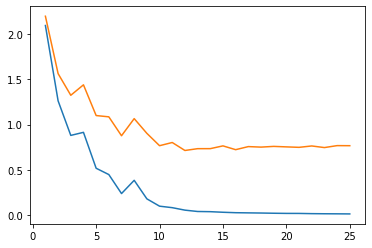

In [ ]:
x=range(1,26)
y1 = []
y2 = []
for i in history[1:26]:
  y1.append(i[0]["train_loss"])
  y2.append(i[2]["test_loss"])
plt.plot(x,y1)
plt.plot(x,y2)

In [ ]:
def evaluate_val(model, val_loader):
    outputs = [model.validation_part(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def evaluate_tst(model, tst_loader):
    outputs = [model.test_part(batch) for batch in tst_loader]
    return model.test_epoch_end(outputs)
def evaluate_trn(model, trn_loader):
    outputs = [model.train_part(batch) for batch in trn_loader]
    return model.train_epoch_end(outputs)
def fit1(epochs, LEARNING_RATE, model, train_loader, val_loader, tst_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(),LEARNING_RATE )
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_part(batch)

           # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        trn_r = evaluate_trn(model, train_loader)
        val_r = evaluate_val(model, val_loader)
        tst_r = evaluate_tst(model, tst_loader)
        print(tst_r['test_acc'])
        model.epoch_end(epoch, trn_r, val_r, tst_r)
        history.append([trn_r, val_r, tst_r])
    return history

In [ ]:
torch.manual_seed(51)
model_p = NeuralNetwork(input_size, out_size = 26).to(device)
model_p.train()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=416, bias=True)
  (linear2): Linear(in_features=416, out_features=208, bias=True)
  (linear3): Linear(in_features=208, out_features=104, bias=True)
  (linear5): Linear(in_features=104, out_features=26, bias=True)
  (relu): ReLU()
)

In [ ]:
history=[]
epochs = 17
history += fit1(epochs, .001, model_p, train_dataloader, val_dataloader, test_dataloader)

25.760509490966797
Epoch [0], train_loss: 2.1796, train_acc: 30.4157
Epoch [0], validation_loss: 2.2102, validation_acc: 30.0926
Epoch [0], test_loss: 2.3614, test_acc: 25.7605

52.986724853515625
Epoch [1], train_loss: 1.2513, train_acc: 58.4880
Epoch [1], validation_loss: 1.2922, validation_acc: 57.9572
Epoch [1], test_loss: 1.4684, test_acc: 52.9867

56.982852935791016
Epoch [2], train_loss: 0.8498, train_acc: 71.0427
Epoch [2], validation_loss: 0.9041, validation_acc: 69.1406
Epoch [2], test_loss: 1.3820, test_acc: 56.9829

64.97511291503906
Epoch [3], train_loss: 0.5688, train_acc: 79.7256
Epoch [3], validation_loss: 0.6099, validation_acc: 77.9369
Epoch [3], test_loss: 1.2216, test_acc: 64.9751

65.26548767089844
Epoch [4], train_loss: 0.3679, train_acc: 86.6358
Epoch [4], validation_loss: 0.3903, validation_acc: 86.1400
Epoch [4], test_loss: 1.2115, test_acc: 65.2655

66.39933776855469
Epoch [5], train_loss: 0.3824, train_acc: 86.3518
Epoch [5], validation_loss: 0.4042, validati

In [ ]:
result = evaluate_tst(model_p, test_dataloader)
result

{'test_loss': 1.0491809844970703, 'test_acc': 81.67864990234375}

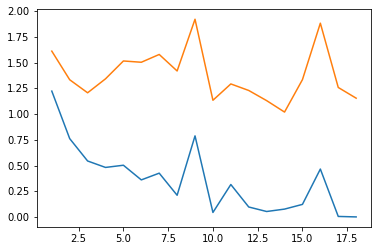

In [ ]:
x=range(1,19)
y1 = []
y2 = []
for i in history[1:19]:
  y1.append(i[0]["train_loss"])
  y2.append(i[2]["test_loss"])
plt.plot(x,y1)
plt.plot(x,y2)

استفاده از اپتیمایزر آدام دقت را افزایش داد.

In [ ]:
class NeuralNetworkdropout(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout()
        self.dropout2 = nn.Dropout()
        self.dropout3 = nn.Dropout()
        self.linear1 = nn.Linear(in_size, 416)
        self.linear2 = nn.Linear(416,208)
        self.linear3 = nn.Linear(208,104)
        self.linear4=nn.Linear(104,26)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        # x = self.dropout1(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.linear3(x)
        x = self.relu(x)
        # x = self.dropout3(x)
        x = self.linear4(x)
        return x
    def training_part(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def train_part(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'train_loss': loss, 'train_acc': acc}
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}

    def validation_part(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def test_part(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'test_loss': loss, 'test_acc': acc}
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

    def epoch_end(self, epoch,  trn_r, val_r, tst_r):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(epoch, trn_r['train_loss'], trn_r['train_acc']))
        print("Epoch [{}], validation_loss: {:.4f}, validation_acc: {:.4f}".format(epoch, val_r['val_loss'], val_r['val_acc']))
        print("Epoch [{}], test_loss: {:.4f}, test_acc: {:.4f}\n".format(epoch, tst_r['test_loss'], tst_r['test_acc']))

In [ ]:
torch.manual_seed(62)
model =NeuralNetworkdropout(input_size, out_size = 26).to(device)
model.train()
history=[]
history = [evaluate_val(model, val_dataloader)]
history
epoch = 79
history += fit(epoch, 0.001, model, train_dataloader, val_dataloader, test_dataloader)

17.36725616455078
Epoch [0], train_loss: 2.7742, train_acc: 18.2223
Epoch [0], validation_loss: 2.7769, validation_acc: 18.1134
Epoch [0], test_loss: 2.8277, test_acc: 17.3673

27.405973434448242
Epoch [1], train_loss: 2.2892, train_acc: 29.2758
Epoch [1], validation_loss: 2.3115, validation_acc: 28.5880
Epoch [1], test_loss: 2.4207, test_acc: 27.4060

32.20409393310547
Epoch [2], train_loss: 1.9095, train_acc: 38.9256
Epoch [2], validation_loss: 1.9363, validation_acc: 37.7894
Epoch [2], test_loss: 2.1317, test_acc: 32.2041

32.59126281738281
Epoch [3], train_loss: 1.7736, train_acc: 42.7356
Epoch [3], validation_loss: 1.7826, validation_acc: 42.7228
Epoch [3], test_loss: 2.1355, test_acc: 32.5913

41.025997161865234
Epoch [4], train_loss: 1.4874, train_acc: 51.1388
Epoch [4], validation_loss: 1.5384, validation_acc: 48.5388
Epoch [4], test_loss: 1.8385, test_acc: 41.0260

41.85564041137695
Epoch [5], train_loss: 1.4176, train_acc: 52.2496
Epoch [5], validation_loss: 1.4435, validatio

In [ ]:
result = evaluate_tst(model, test_dataloader)
result

{'test_loss': 1.1706476211547852, 'test_acc': 76.46570587158203}

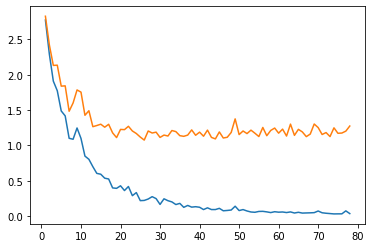

In [ ]:
x=range(1,79)
y1 = []
y2 = []
for i in history[1:79]:
  y1.append(i[0]["train_loss"])
  y2.append(i[2]["test_loss"])
plt.plot(x,y1)
plt.plot(x,y2)

In [ ]:
torch.manual_seed(13)
model =NeuralNetworkdropout(input_size, out_size = 26).to(device)
model.train()

NeuralNetworkdropout(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=784, out_features=416, bias=True)
  (linear2): Linear(in_features=416, out_features=208, bias=True)
  (linear3): Linear(in_features=208, out_features=104, bias=True)
  (linear4): Linear(in_features=104, out_features=26, bias=True)
  (relu): ReLU()
)

In [ ]:
history = []
history = [evaluate_val(model, val_dataloader)]
history

[{'val_loss': 13.87363052368164, 'val_acc': 4.513888835906982}]

In [ ]:
history += fit1(63, 0.0003, model, train_dataloader, val_dataloader, test_dataloader)
history += fit1(20, 0.00005, model, train_dataloader, val_dataloader, test_dataloader)

6.775442600250244
Epoch [0], train_loss: 2.9764, train_acc: 7.2028
Epoch [0], validation_loss: 2.9814, validation_acc: 7.5087
Epoch [0], test_loss: 3.0091, test_acc: 6.7754

10.038717269897461
Epoch [1], train_loss: 2.8164, train_acc: 11.3958
Epoch [1], validation_loss: 2.8325, validation_acc: 11.4439
Epoch [1], test_loss: 2.9018, test_acc: 10.0387

14.518805503845215
Epoch [2], train_loss: 2.5413, train_acc: 16.5579
Epoch [2], validation_loss: 2.5572, validation_acc: 15.7552
Epoch [2], test_loss: 2.6547, test_acc: 14.5188

22.842920303344727
Epoch [3], train_loss: 2.1198, train_acc: 27.2206
Epoch [3], validation_loss: 2.1647, validation_acc: 25.5932
Epoch [3], test_loss: 2.3044, test_acc: 22.8429

32.508296966552734
Epoch [4], train_loss: 1.8304, train_acc: 37.4337
Epoch [4], validation_loss: 1.8676, validation_acc: 35.8362
Epoch [4], test_loss: 2.0588, test_acc: 32.5083

40.69413757324219
Epoch [5], train_loss: 1.6089, train_acc: 45.8280
Epoch [5], validation_loss: 1.6404, validation

In [ ]:
evaluate_tst(model, test_dataloader)

{'test_loss': 2.0562191009521484, 'test_acc': 79.77046203613281}

In [ ]:
len(history)

84

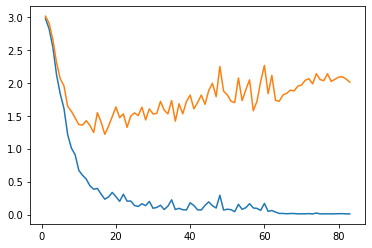

In [ ]:
x=range(1,84)
y1 = []
y2 = []
for i in history[1:84]:
  y1.append(i[0]["train_loss"])
  y2.append(i[2]["test_loss"])
plt.plot(x,y1)
plt.plot(x,y2)

در حالتی که از شبکه بدون دراپ‌اوت و اپتیمایزر اس.جی.دی استفاده شد دقت 79.9 به دست آمد.استفاده از الگوریتم آدام در این حالت دقت 81.67 را داد. در این دو حالت با اضافه شدن یک لایه دراپ اوت به شبکه دقت‌ها به ترتیب 76.5 و 79.7 شد. در هر دو شبکه با استفاده از اپتیمایزر آدام دقت افزایش پیدا کرد. به صورت کلی دراپ اوت روند آموزش را سریع تر کرد و به نظر می رسد در  صورتی که برای به دست آوردن دقت بالاتر تلاش شود دقت بهتری هم خواهد داد.

d:

بهترین شبکه به دست آمده شبکه‌ اول و با الگوریتم اپتیمایزیشن آدام است

accuracy: 81.67

e:

In [ ]:
model_p

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=416, bias=True)
  (linear2): Linear(in_features=416, out_features=208, bias=True)
  (linear3): Linear(in_features=208, out_features=104, bias=True)
  (linear5): Linear(in_features=104, out_features=26, bias=True)
  (relu): ReLU()
)

In [ ]:
import cv2 as cv
import numpy as np
img_u = cv.imread('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw2/hand_signs/u.jpg')
img_v = cv.imread('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw2/hand_signs/v.jpg')
img_w = cv.imread('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw2/hand_signs/w.jpg')
img_y = cv.imread('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw2/hand_signs/y.jpg')
images = [img_u, img_v, img_w, img_y]
images_gray = []
for img in images:
  img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img_gray_rs = cv.resize(img_gray, (28, 28))
  img_gray_rs_f = cv.resize(img_gray, (1,28*28))
  images_gray.append(img_gray_rs_f)
images_gray = np.array(images_gray)

In [ ]:
im_z_m = images_gray - images_gray.mean(axis=0)
im_z_m_u_v = im_z_m/im_z_m.std()
im_z_m_u_v.shape
im_z_m_u_v
labels = np.array([[20], [21], [22], [24]])
labels = np.array(labels)
t_images = im_z_m_u_v.reshape(im_z_m_u_v.shape[0],1,28,28)
X = torch.from_numpy(t_images).type(torch.float32).to(device)
y = torch.from_numpy(labels).type(torch.int64).to(device)
test_f = TensorDataset(X, y)
my_test_data = DataLoader(test_f,4,  shuffle=True)


In [ ]:
for i, j in my_test_data:
  print(i.shape, j.shape)

torch.Size([4, 1, 28, 28]) torch.Size([4, 1])


In [ ]:
predicted_label = model_p.forward(X).argmax(1)
true_label =[20,21,22,24]
print(predicted_label,"\n", true_label)

tensor([12, 15, 22, 11]) 
 [20, 21, 22, 24]
